In [163]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torch import Tensor, LongTensor
from torch.nn.init import xavier_normal

from torch.utils.data import DataLoader, Dataset

import numpy as np

import os
import random

from tqdm import tqdm_notebook

from pycrayon import CrayonClient

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.Size([64, 100])
0.0


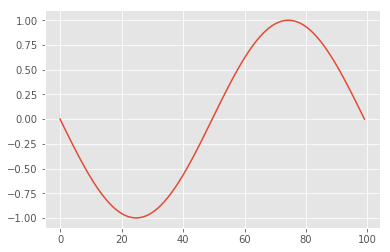

2.0


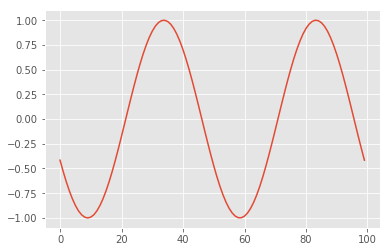

TypeError: list indices must be integers or slices, not float

In [164]:
D_hid = 32
G_hid = 512 

mb_size = 64
seq_len = 100
z_dim = 100
c_dim = 1
n_classes = 6


rs = (-4,4)
rf = (5,50)

pi = np.pi

cond_shifts_choices = [0.5, 1, 1.5]
init_shifts_choices = [0, -1.7, 2.7]

def get_batch():
    support = np.linspace(-pi, pi, seq_len)
    cond_shifts_choices = [0.5, 1, 1.5, 0.25, 0.75, 1.25, 1.75, 2]
    init_shifts_choices = [0, -1.7, 2.7]
    labels = range(len(cond_shifts_choices))
    lookup_cond = {shift: label for shift, label in zip(cond_shifts_choices, labels)}
    lookup_init = {shift: label for shift, label in zip(init_shifts_choices, labels)}
    
    init_shifts = np.random.choice(init_shifts_choices, mb_size)
    cond_shifts = np.random.choice(cond_shifts_choices, mb_size)
    zs = np.array([np.sin((support + init_shifts[i])) 
                   for i in range(mb_size)])
    target = np.array([np.cos((support*2 + init_shifts[i] + cond_shifts[i])) 
                   for i in range(mb_size)])
    
    #c_init = [lookup_init[s] for s in init_shifts]
    #c_cond = [lookup_cond[s] for s in cond_shifts]
    
    #return Tensor(zs), Tensor(target), LongTensor(c_init), LongTensor(c_cond) 
    return Tensor(zs), Tensor(target), Tensor(init_shifts), Tensor(cond_shifts) 
    
    
z, t, ci, cc = get_batch()
print(z.size())
plt.plot(z.numpy().T[:,0])
print(ci[0])
plt.show()
plt.plot(t.numpy().T[:,0])
print(cc[0])
plt.show()
support = np.linspace(-pi, pi, seq_len)
plt.plot(np.sin(support + init_shifts_choices[ci[0]] + cond_shifts_choices[cc[0]]))
plt.show()

In [ ]:
class Logger():
    def __init__(self, exp_name):
        self.cc = CrayonClient(hostname='localhost')
        names = self.cc.get_experiment_names()
        self.cc.remove_experiment(exp_name)
        self.exp = self.cc.create_experiment(exp_name)
        
    def log_scalar(self, key, val):
        self.exp.add_scalar_value(key, val)
        
    def log_hist(self, key, val):
        self.exp.add_histogram_value(key, val, tobuild=True)

In [165]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(n_classes, c_dim)
        self.l1 = nn.Linear(z_dim + c_dim*2, G_hid)
        self.l2 = nn.Linear(G_hid, G_hid)
        self.l3 = nn.Linear(G_hid, seq_len)
        
    def forward(self, z, cf=None, cs=None):
        #cf = self.embed(cf)
        #cs = self.embed(cs)
        cf = cf.unsqueeze(1)
        cs = cs.unsqueeze(1)
        
        c = torch.cat([cf, cs], 1)
        inp = torch.cat([z, c], 1)
        h = F.relu(self.l1(inp))
        h = F.relu(self.l2(h))
        output = F.tanh(self.l3(h))
        return output
    
    def init_weights(self):
        for name, param in self.named_parameters(): 
            if param.dim() >= 2:
                xavier_normal(param)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__() 
        self.embed = nn.Embedding(n_classes, c_dim)
        self.l1 = nn.Linear(seq_len + c_dim*2, D_hid)
        self.l2 = nn.Linear(D_hid, 1)
    
    def forward(self, X, cf=None, cs=None):
        #cf = self.embed(cf)
        #cs = self.embed(cs)
        cf = cf.unsqueeze(1)
        cs = cs.unsqueeze(1)
        c = torch.cat([cf, cs], 1)
        inp = torch.cat([X, c], 1)
        h = F.relu(self.l1(inp))
        y = self.l2(h)
        return y
    
    def init_weights(self):
        for name, param in self.named_parameters(): 
            if param.dim() >= 2:
                xavier_normal(param)
                
    def grad_penalty(self, real_data, fake_data, cf, cs):
        alpha = torch.rand(mb_size, 1)
        alpha = alpha.expand(real_data.size())
        alpha = alpha.cuda() 

        interpolates = alpha * real_data.data + ((1 - alpha) * fake_data.data)
        interpolates = autograd.Variable(interpolates, requires_grad=True)
        
        disc_interpolates = self.forward(interpolates, cf, cs)
        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 1
        return gradient_penalty
    
G = Generator()
G.init_weights()
D = Discriminator()
D.init_weights()
G.cuda()
D.cuda()

ones_label = Variable(torch.ones(mb_size, 1)).cuda()
zeros_label = Variable(torch.zeros(mb_size, 1)).cuda()

G_solver = optim.SGD(G.parameters(), lr=1e-4)
D_solver = optim.Adamax(D.parameters(), lr=1e-3)
#G_solver = optim.RMSprop(G.parameters(), lr=1e-3)
#D_solver = optim.RMSprop(D.parameters(), lr=1e-3)

def reset_grad():
    D.zero_grad()
    G.zero_grad() 
G

Generator (
  (embed): Embedding(6, 1)
  (l1): Linear (102 -> 512)
  (l2): Linear (512 -> 512)
  (l3): Linear (512 -> 100)
)

In [166]:
def show_seqs(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d.T[:,::ds])
    if title:
        plt.title('Loss {}:'.format(title))
    plt.savefig('pics/train_epoch{}.pdf'.format(i))
    plt.plot(d.T[:,::ds])
    if title:
        plt.title('Loss {}:'.format(title))
    plt.show()

def show_seqs_aux(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d.T[:,::ds])
    if title:
        plt.title(title)
    plt.savefig('{}.pdf'.format(i))
    plt.plot(d.T[:,::ds])
    if title:
        plt.title(title)
    plt.show()
    
def show_seqs_nosave(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d.T[:,::ds])
    plt.show()   
    
def freeze(model):
    for p in model.parameters():
        p.requires_grad = False

def unfreeze(model):
    for p in model.parameters():
        p.requires_grad = True
        
one = torch.FloatTensor([1])
mone = one * -1
one = one.cuda()
mone = mone.cuda()


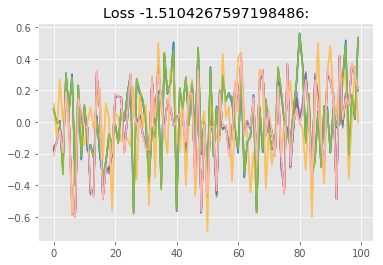

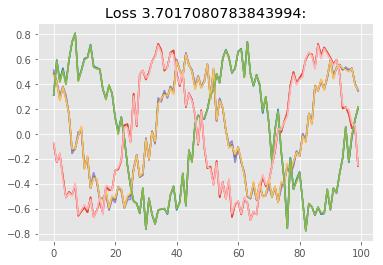

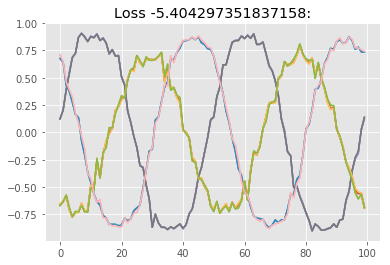

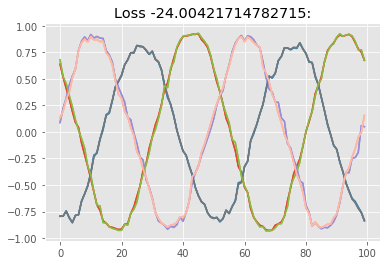

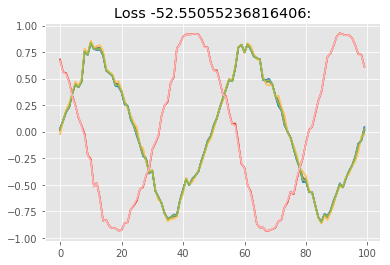

KeyboardInterrupt: 

In [167]:
e_bar = tqdm_notebook(range(1000))
G_losses = [1]
D_losses = [1]
logger = Logger('GAN-RNN-SIN')
for j, it in enumerate(e_bar):
    G_loss_avg = 0
    D_loss_avg = 0
    n_batches = 100
    b_bar = tqdm_notebook(range(n_batches), leave=False)
    
    DD = D_losses[-1]
    GG = G_losses[-1]
    
    for i in b_bar:
        #z = Variable(g_noise()).cuda()
        z, X, cf, cs = get_batch()
        z = Variable(z.cuda())
        X = Variable(X.cuda())
        cf = Variable(cf.cuda())
        cs = Variable(cs.cuda())
        
        G_sample = G(z, cf, cs)
        D_real = D(X, cf, cs).mean()
        D_real.backward(mone)
        D_fake = D(G_sample, cf, cs).mean()
        D_fake.backward(one)
        gp = D.grad_penalty(X, G_sample, cf, cs)
        gp.backward()
        D_cost = D_fake - D_real + gp
        D_loss = D_real - D_fake
        D_solver.step()
        D_loss = D_loss.data[0]
        reset_grad()
        
        for _ in range(1):
            z, _, cf, cs = get_batch()
            z = Variable(z.cuda())
            cf = Variable(cf.cuda())
            cs = Variable(cs.cuda())
            G_sample = G(z, cf, cs)
            D_fake = D(G_sample, cf, cs)
            G_loss = D_fake.mean()
            G_loss.backward(mone)
            G_cost = -G_loss
            G_solver.step()
            G_loss = G_loss.data[0]
            reset_grad()
        
        D_loss_avg += D_loss
        G_loss_avg += G_loss
        
        
    G_losses.append(G_loss_avg / n_batches)
    D_losses.append(D_loss_avg / n_batches)
    G_loss_avg = 0
    D_loss_avg = 0
    
    t = D_fake.mean().data.cpu().numpy().flatten()[0]
    if j%10 == 0:
        show_seqs(G_sample, j, t, ds=10)
    logger.log_scalar('loss/Disciminator', D_losses[-1])
    logger.log_scalar('loss/Generator', G_losses[-1])
    e_bar.set_postfix(
        G_loss=G_losses[-1],
        D_loss=D_losses[-1],
    )

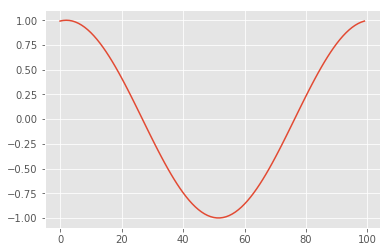

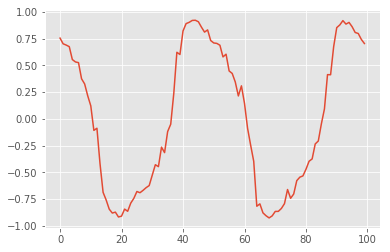

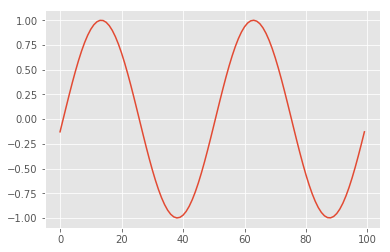

In [170]:
for _ in range(1):
    z, X, cf, oks = get_batch()
    ex = 1
    #cf = Variable(torch.ones(ex)).long().cuda() * 0
    z = Variable(z).cuda()
    cf = Variable(cf).cuda()
    cs = Variable(torch.ones(ex)).float().cuda() * 0
    G_sample = G(z[0:ex,:], cf[0:1], cs)
    ds = 1
    show_seqs_nosave(z[0:ex], ds=ds)
    show_seqs_nosave(G_sample[0:ex], ds=ds)
    
    support = np.linspace(-pi, pi, seq_len)
    plt.plot(np.cos(support*2 + cf.data[0] + cs.data[0]))

In [ ]:
for _ in range(1):
    z = Variable(g_noise()).cuda()
    c = Variable(torch.ones(5)).long().cuda() * 2
    G_sample = G(z[0:5,:], c)
    ds = 1
    show_seqs_nosave(z, ds=ds)
    show_seqs_aux(z[0:5],'input_noise', 'noise', ds=ds)
    #show_seqs_aux(G_sample,'gen', 'condition: 2', ds=ds)